# Aplicando Inteligência Artificil para prever a média mensal de vendas
Deep learning -Modelo LSTM

Os problemas de previsão de séries temporais são um tipo dificil de problema de modelagem preditiva. As séries temporais adicionam a complexidade de uma sequência entre as variáveis de entrada.
Um tipo poderoso de rede neural projetada para lidar com a dependência de sequência é chamado de Rede neural recorrente. A rede Long Short-term memory ou LSTM é um tipo de rede neural recorrente usada em apredizado profundo que apresenta bons resultados, quando devidamente treinada.


In [42]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
matplotlib.style.use('ggplot')
%matplotlib inline

# Definição do Problema de Negócio
A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail, a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros).

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.

Esse é nosso trabalho.

In [43]:
# Carrega os dados
data = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [44]:
# Shape
data.shape

(9994, 21)

In [45]:
# Colunas
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [46]:
# Visualizando os dados
data.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [47]:
# Resumo estatístico
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [48]:
# Checando valores missing - não temos valores missing no dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [49]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
data.columns = map(str.lower, data.columns)

In [50]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")

In [51]:
# Conferindo
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [52]:
# separando os dados por categoria
df_technology = data.loc[data['category']=='Technology']
df_furniture = data.loc[data['category']=='Furniture']
df_office = data.loc[data['category']=='Office Supplies']

In [53]:
# Agregando as vendas pela data do pedido
ts_technology = df_technology.groupby('order_date')['sales'].sum().reset_index()
ts_furniture = df_furniture.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

In [54]:
ts_technology

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


In [55]:
# colocando a data como indice
ts_technology = ts_technology.set_index('order_date')

In [56]:
ts_technology

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


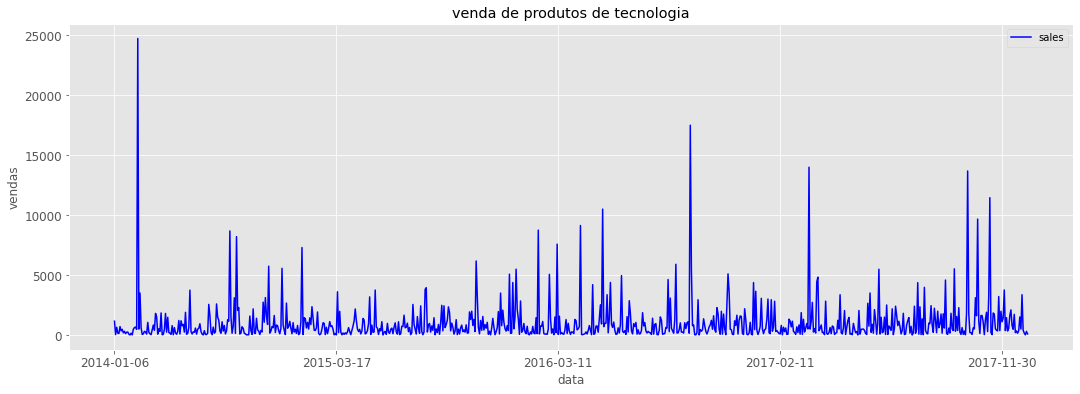

In [57]:
# venda de produtos de Tecnologia
technology_sales = ts_technology[['sales']]
ax = technology_sales.plot(color ='b',figsize=(18,6))
plt.xlabel("data")
plt.ylabel("vendas")
plt.title("venda de produtos de tecnologia")
plt.show()

Vamos ajustar o indice do tipo index para o tipo date timeindex ( o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo.

In [58]:
# conferindo o tipo do índice
type(technology_sales.index)

pandas.core.indexes.base.Index

In [59]:
# Alterando o tipo do índice
technology_sales.index = pd.to_datetime(technology_sales.index)

In [60]:
type(technology_sales.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [61]:
# reamostrando os dados para frequência mensal
# usando o valor médio das vendas diárias - definimos o mês como índice
technology_sales_average = technology_sales['sales'].resample('MS').mean()

In [62]:
# Verificando o tipo resultante
type(technology_sales_average)

pandas.core.series.Series

In [63]:
# checando os dados
technology_sales_avarege

NameError: name 'technology_sales_avarege' is not defined

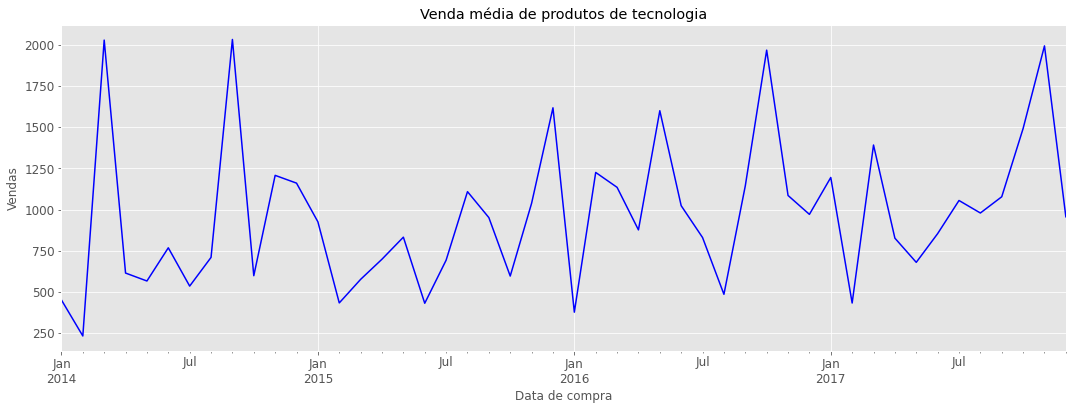

In [ ]:
# Venda média de produtos de tecnologia
technology_sales_average.plot(figsize=(18,6),color='blue')
plt.xlabel('Data de compra')
plt.ylabel('Vendas')
plt.title('Venda média de produtos de tecnologia')
plt.show()

Vamos decompor uma das séries para avaliar seus componentes.

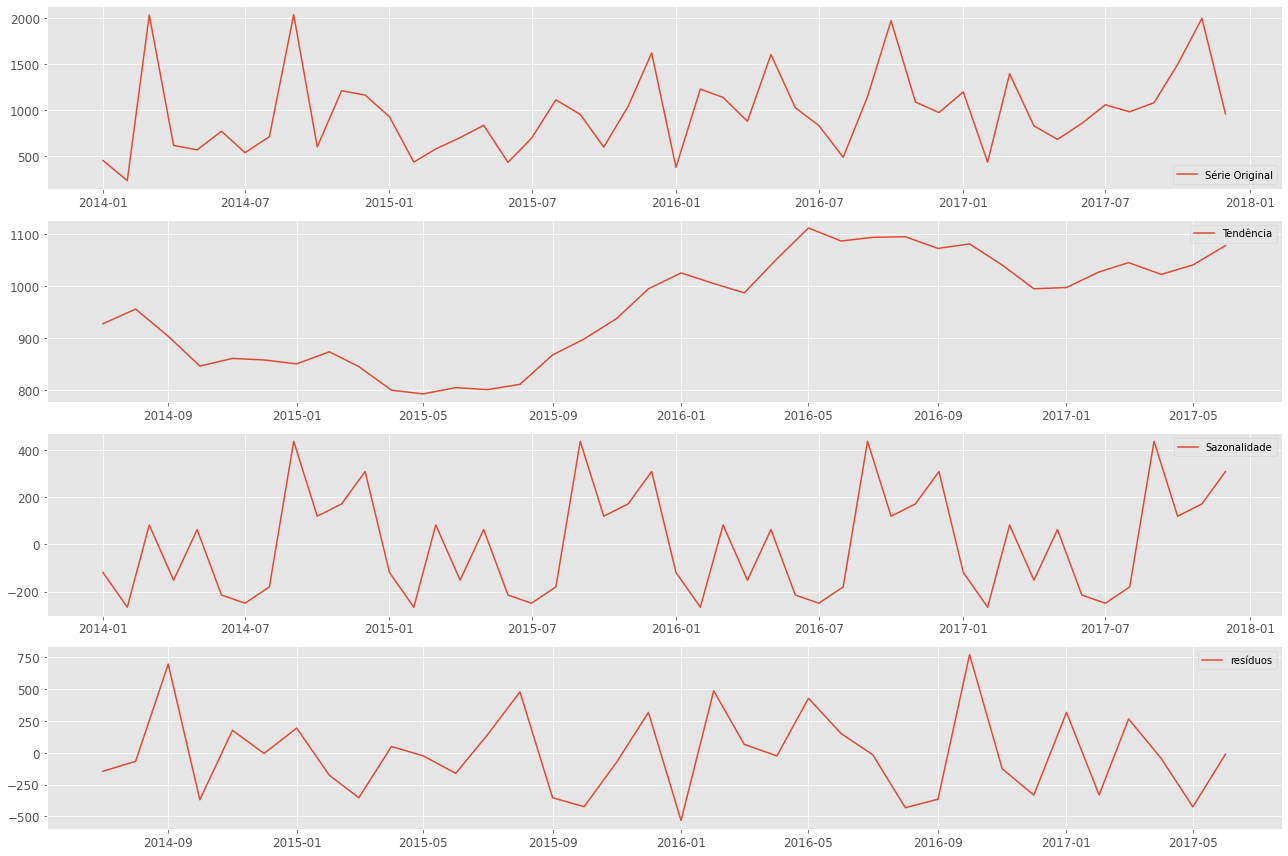

In [ ]:
# decomposição de série temporal de vendas média de produtos de tecnologia
decomposition = seasonal_decompose(technology_sales_average,period = 12)
rcParams['figure.figsize'] = 18,12

# componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot
plt.subplot(411)
plt.plot(technology_sales_average,label ='Série Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Tendência')
plt.legend(loc ='best')
plt.subplot(413)
plt.plot(seasonal,label='Sazonalidade')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label ='resíduos')
plt.legend(loc ='best')
plt.tight_layout()


In [ ]:
# função para testar a estacionaridade
def stationarity(serie):
    # calcula estatística móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # plot estatísticas móveis
    orig = plt.plot(serie, color='blue',label='Original')
    mean=plt.plot(rolmean, color ='red',label='média móvel')
    std = plt.plot(rolstd,color ='black',label='Desvio padrão')
    plt.legend(loc='best')
    plt.title('Estatísticas móveis - média e desvio padrão')
    plt.show()

    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do teste Dickey-Fuller:\n')

    # Teste
    dfTest = adfuller(serie,autolag='AIC')

    # fomatando a saída
    dfout= pd.Series(dfTest[0:4],index=['Estatística do Teste',
                                        'Valor-p',
                                        'Número e lags considerados',
                                        'Número de observações usadas'])
    for key, value in dfTest[4].items():
        dfout['Valor cŕitico (%s)'%key] = value
    print(dfout)
        
    print('\nConclusão:')
    if dfout[1]>0.05:
        print('\no valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária')
    else:
        print('\no valor-p é menor que 0.05 e, portanto temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária')
    
        

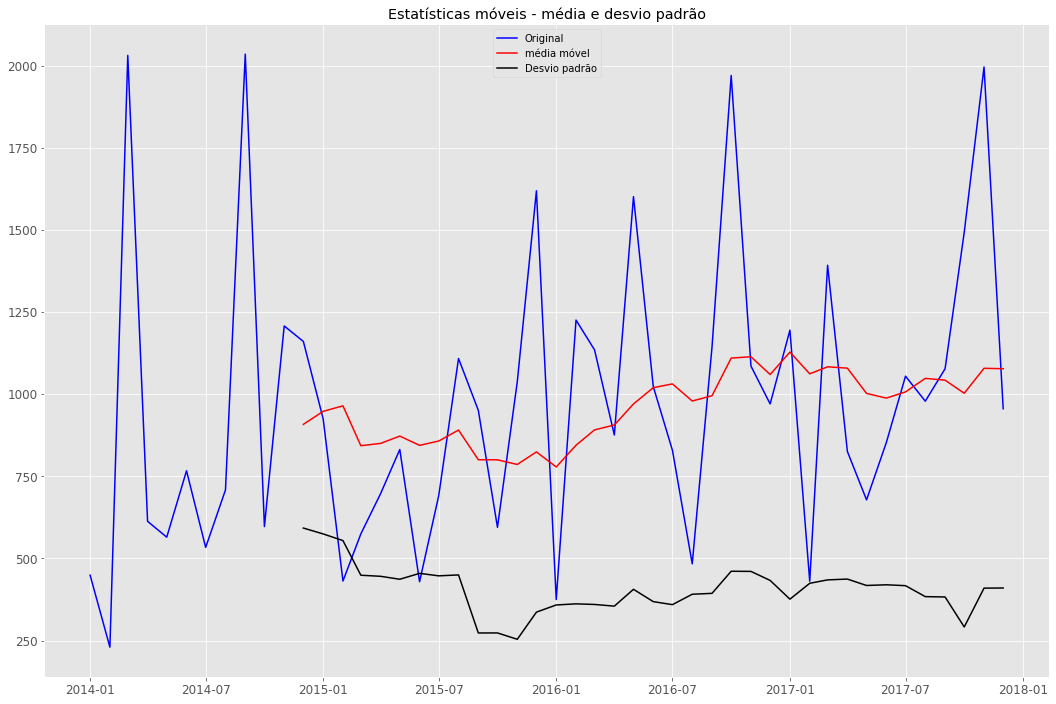


Resultado do teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número e lags considerados      0.000000e+00
Número de observações usadas    4.700000e+01
Valor cŕitico (1%)             -3.577848e+00
Valor cŕitico (5%)             -2.925338e+00
Valor cŕitico (10%)            -2.600774e+00
dtype: float64

Conclusão:

o valor-p é menor que 0.05 e, portanto temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária


In [ ]:
# Verifica se a série é estacionária
stationarity(technology_sales_average)

# Dados de treino e teste

In [65]:
# Série original
x = technology_sales_average

In [66]:
# Os primeiros 36 registros da série serão usados como dados de treino
x[:12]

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
Freq: MS, Name: sales, dtype: float64

In [67]:
# Os ultimos 12 registros da śerie serão usados como dados de teste
x[-12:]

order_date
2017-01-01    1195.218071
2017-02-01     430.501714
2017-03-01    1392.859250
2017-04-01     825.559133
2017-05-01     678.329400
2017-06-01     853.055000
2017-07-01    1054.996636
2017-08-01     978.842333
2017-09-01    1077.704120
2017-10-01    1493.439227
2017-11-01    1996.750920
2017-12-01     955.865652
Freq: MS, Name: sales, dtype: float64

In [68]:
# Divisão em treino e teste
train, test = np.array(x[:-12]),np.array(x[-12:])

In [69]:
# Ajusta o shape pois agora não temos um objeto pd.Series,
# Mas sim um array Numpy, que é necessário para trainar o modelo LSTM
trainset = train.reshape(-1,1)
testset = test.reshape(-1,1)


In [70]:
len(trainset)

36

In [71]:
trainset

array([[ 449.04142857],
       [ 229.78714286],
       [2031.948375  ],
       [ 613.02893333],
       [ 564.69858824],
       [ 766.90590909],
       [ 533.60893333],
       [ 708.43538462],
       [2035.83813333],
       [ 596.9009    ],
       [1208.05632   ],
       [1160.73288889],
       [ 925.0708    ],
       [ 431.12125   ],
       [ 574.66233333],
       [ 697.5595    ],
       [ 831.64285714],
       [ 429.0244    ],
       [ 691.39773333],
       [1108.90228571],
       [ 950.8564    ],
       [ 594.71611111],
       [1037.98265217],
       [1619.63763636],
       [ 374.67106667],
       [1225.8914    ],
       [1135.15010526],
       [ 875.91188235],
       [1601.81616667],
       [1023.2595    ],
       [ 829.3125    ],
       [ 483.6201    ],
       [1144.1703    ],
       [1970.835875  ],
       [1085.64236   ],
       [ 970.55486957]])

In [ ]:
len(testset)

12

In [72]:
testset

array([[1195.21807143],
       [ 430.50171429],
       [1392.85925   ],
       [ 825.55913333],
       [ 678.3294    ],
       [ 853.055     ],
       [1054.99663636],
       [ 978.84233333],
       [1077.70412   ],
       [1493.43922727],
       [1996.75092   ],
       [ 955.86565217]])

# Função para cálculo da acurácia

In [ ]:
def performace(y_true,y_pred):
    mse = ((y_pred-y_true)**2).mean()
    mape = np.mean(np.abs((y_true-y_pred)/y_true))*100
    return print('MSE das previsões é {}'.format(round(mse,2))+
                '\nRMSE da previsões é {}'.format(round(np.sqrt(mse),2))+
                '\nMAPE das previsões é {}'.format(round(mape,2)))

# Modelo LSTM
A rede Long Short-Term Memory, ou LSTM, é uma rede neural recorrente treinada usando Backpropagation Through Time e supera o problema da dissipação do gradiente ( isso é explicado no Deep Learning Book).
Como tal, o modelo pode ser usado para criar grandes redes rocorrentes que, por sua vez podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.
Em vez de neurônios, as redes LSTM possuem blocos  de memória conectados através de camadas.
Um bloco possui componentes que o tornam mais inteligente que um neurônio clássico e uma memória para sequências recentes, Um bloco contém portas que gerenciam o estado e a saída do bloco. Um bloco opera sobre uma sequência de entrada e cada porta dentro de um bloco usa as unidades de ativação sigmóide para controlar se são acionada ou não, condicionando a mudança de estado e a adição de informações que fluem através do blobo.
Existem três tipos de portas dentro de uma unidade:
Forget Gate: decide condicionalmente quais informações jogar fora do bloco.
Input Gate decide condicionalmente quais valores de entrada atualizar o estado da memória.
Output Gate: decide condicionalmente o que enviar com base na entrada e na memória do bloco.
Cada Unidade é como uma máquina de mini estado onde os portões das unidades têm pesos que são aprendidos durantes o procedimento de treinamento.


# preparando os dados para treinamento
Como regra geral, sempre que vocÊ usa ma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entra 0 e 1, o parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intervalo será entra 0 e 1.

In [73]:
# Cria o scaler
scaler = MinMaxScaler()

In [74]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)


MinMaxScaler()

In [75]:
# Aplica o mesmo scaler aos dados de treino
# (não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelos)
trainset = scaler.transform(trainset)

In [76]:
trainset.shape

(36, 1)

In [77]:
trainset

array([[0.12139983],
       [0.        ],
       [0.99784626],
       [0.21219877],
       [0.18543853],
       [0.29739956],
       [0.16822437],
       [0.26502477],
       [1.        ],
       [0.20326877],
       [0.54166199],
       [0.51545928],
       [0.38497454],
       [0.11147753],
       [0.1909554 ],
       [0.25900285],
       [0.33324403],
       [0.11031652],
       [0.25559112],
       [0.48676098],
       [0.39925188],
       [0.20205906],
       [0.44749318],
       [0.76955219],
       [0.08022139],
       [0.55153717],
       [0.50129424],
       [0.35775554],
       [0.75968454],
       [0.43934106],
       [0.33195373],
       [0.14054584],
       [0.50628867],
       [0.96400863],
       [0.47388209],
       [0.41015881]])

In [89]:
# aqui definimos os hiperparâmetros
n_rep = 20
# Número de epochs
num_epochs = 200
# número de inputs (usaremos 12 séries para prever as 12 séries seguintes)
n_input = 12
# comprimento das sequências de saída (em número de timestemp)
n_output = 12
# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1
# Número de amostras de séries temporais em cada lote
size_bath =10

O timeseiresGenerator do keras transforma automaticamente um conjunto de dados univariado em séries temporais em um dataset para problema de apredizado supervisionado.


In [90]:
# Generator
generator = TimeseriesGenerator(trainset,
                                trainset,
                                length=n_output,
                                batch_size=size_bath)

Podemos agora criar o modelo
Para começar a aplicação de deep learning ao nosso problema criaremos ummodelo básico de LSTM que chamarei de LSTM padrão.
Aqui está a principal diferença dos modelos de deep Learning para outros métodos de previsão de séries temporais. Temos que criar o modelo com cada camada de rede neural.
Como trabalharemos com batches de dados da séries que serão passados pela rede várias vezes, vamos cria o modelo e gerar os batches de dados a cada passada de um loop. As camadas de rede nada mais são que operações matemáticas.
Nas próximas aulas ensinarei a você como definir os parâmetros da rede (como número de naurônios de dropout).

In [95]:
# criação e treinamento do modelo LSTM padrão
#Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
result =np.zeros((n_input,n_rep))

# Loop 
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todoso os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.

for i in range(n_rep):

    # O primeiro passo é criar o modelo, ou seja , um objeto da classe sequential() do keras
    model_lstm = Sequential()

    # podemos adicionar agora a primeira camada da rede, ou camada de entrada.Series# esta é a camada que recebe os dados]
    model_lstm.add(LSTM(50 , activation = 'relu', input_shape = (n_input,n_features)))

    # A camada de Dropout aplica regularização à rede, removendo alguns neurônios e evitando overfitting
    model_lstm.add(Dropout(0.10))

    # Adicionamos a segunda camada intermedíaria ou oculta
    model_lstm.add(Dense(100,activation='relu'))
    # Adicionamos a segunda camada intermediária ou oculta
    model_lstm.add(Dense(100, activation='relu'))

    # Adicionamos a camada de saída de tudo que precisamos é de 1 neurônio pois estamos prevendo apenas 1 valor
    model_lstm.add(Dense(1))
    
    # com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE(Mean Squared Error)
    # e indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    model_lstm.compile(optimizer='adam',loss='mean_squared_error')

    # Aqui fazemos o treinamento gerando batches de dados
    model_lstm.fit_generator(generator,epochs=num_epochs)

    # Lista para as previsões
    pred_list = []
    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1,n_input,n_features))

    # Loop para fazer as previsões
    for j in range(n_input):
        pred_list.append(model_lstm.predict(batch)[0])
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

        # Gera o dataframe com as previsões
        df_predict_model_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                            index=x[-n_input:].index,columns=['Prediction'])
        result[:,i] = df_predict_model_lstm["prediction"]
print(result)

Epoch 1/200
3/3 [==============================] - 1s 5ms/step - loss: 0.1465
Epoch 2/200
3/3 [==============================] - 0s 7ms/step - loss: 0.1044
Epoch 3/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1135
Epoch 4/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0731
Epoch 5/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0561
Epoch 6/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0646
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0709
Epoch 8/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0624
Epoch 9/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0555
Epoch 10/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0512
Epoch 11/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0513
Epoch 12/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0618
Epoch 13/200
3/3 [==============================] - 0s 6ms/st

ValueError: Shape of passed values is (1, 1), indices imply (12, 1)

In [78]:
n = 'nildo é frango@?%'

re = [hex(ord(x)) for x in n]

re

['0x6e',
 '0x69',
 '0x6c',
 '0x64',
 '0x6f',
 '0x20',
 '0xe9',
 '0x20',
 '0x66',
 '0x72',
 '0x61',
 '0x6e',
 '0x67',
 '0x6f',
 '0x40',
 '0x3f',
 '0x25']

In [79]:
resp = ''
for value in re:
    resp = resp + str(value)
    print(resp)

0x6e
0x6e0x69
0x6e0x690x6c
0x6e0x690x6c0x64
0x6e0x690x6c0x640x6f
0x6e0x690x6c0x640x6f0x20
0x6e0x690x6c0x640x6f0x200xe9
0x6e0x690x6c0x640x6f0x200xe90x20
0x6e0x690x6c0x640x6f0x200xe90x200x66
0x6e0x690x6c0x640x6f0x200xe90x200x660x72
0x6e0x690x6c0x640x6f0x200xe90x200x660x720x61
0x6e0x690x6c0x640x6f0x200xe90x200x660x720x610x6e
0x6e0x690x6c0x640x6f0x200xe90x200x660x720x610x6e0x67
0x6e0x690x6c0x640x6f0x200xe90x200x660x720x610x6e0x670x6f
0x6e0x690x6c0x640x6f0x200xe90x200x660x720x610x6e0x670x6f0x40
0x6e0x690x6c0x640x6f0x200xe90x200x660x720x610x6e0x670x6f0x400x3f
0x6e0x690x6c0x640x6f0x200xe90x200x660x720x610x6e0x670x6f0x400x3f0x25


In [97]:
arr ='pichototinha'
bytearray(arr)

TypeError: string argument without an encoding